In [24]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import pickle

In [25]:
# Test batches to indicate how many batches of generated images will be tested
test_batches = 100

# Batch size, which will be used to generate image
batch_size = 64

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Size of feature maps in generator
ngf = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Target class and current cluster
target_class = 2
curr_cluster = 0

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# The read path of Generator
generator_read_dir = "./generator_save/{}_{}.pt".format(target_class, curr_cluster)

In [26]:
# Load pickle files of kmeans

kmeans_read_dir = "./kmeans_pickle_save/{}.pickle".format(target_class)

kmeans_pickle = open(kmeans_read_dir, "rb")
kmeans = pickle.load(kmeans_pickle)
print(kmeans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)


In [27]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [28]:
# Load the generator
netG = Generator(ngpu=ngpu).to(device)
netG.load_state_dict(torch.load(generator_read_dir))
netG.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

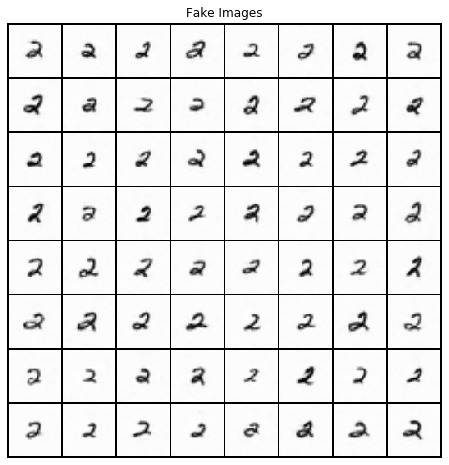

In [29]:
# Create batch of latent vectors and get fake images
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
fake = netG(fixed_noise).detach().cpu()

# Plot the fake images from the last epoch
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True), (1,2,0)))
plt.show()

In [30]:
# Generate several batches of data and use kmeans to cluster them
#
# Remember that our Generator is trained on one cluster,
# therefore, if the generated image is still clustered into the same cluster
# we will regard this image as a correct one

correct_num = 0
for i in range(test_batches):
    # Create batch of latent vectors and get fake images
    fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
    fake = netG(fixed_noise).detach().cpu()

    # Resize the image to 28*28
    fake_np = fake.numpy()
    res_images = []
    for i in range(batch_size):
        im = np.squeeze(fake_np[i, :, :, :])
        im = Image.fromarray(np.uint8(im * 255))
        im = im.resize((28, 28))
        resized_im = np.array(im)
        res_images.append(resized_im.reshape(-1).astype(np.float) / 255)

    # Aggregate results
    fake_np = np.stack(res_images)

    # Get kmeans clustering result
    predict_res = kmeans.predict(fake_np)
    counter = Counter(predict_res)
    correct_num += counter[curr_cluster]

print("Accuracy: {}".format(correct_num / (test_batches * batch_size)))

Accuracy: 0.8565625
